# Advanced Lane Finding Project

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify (dt. ausrichten) binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [1]:
#importing some useful packages

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob # glob API for importing list of (calibration) images
#from cal_undistort import cal_undistort

## Camera calibration using chessboard images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # nx=9 and ny=6

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

"""
img = plt.imread('camera_cal/calibration1.jpg')
plt.imshow(img)
"""

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg') # importing the glob API

# print(images[0]) # DEBUG

# Step through the list and search for chessboard corners and if found, add object and image points (needed later in cv.calibrateCamera())
for fname in images:
    img = plt.imread(fname)
    # no cv2.undistort(img, mtx, dist, None) here because cal images are not distorted (only the first one a little bit maybe)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # why? to find corners easily in the next step
                                                # if you are using cv2.imread() or the glob API, as happens here,
                                                # this will read in a BGR image and you should convert to grayscale
                                                # using cv2.COLOR_BGR2GRAY.

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None) # nx=9 and ny=6 (ret=return)

    # If found, add object points, image points
    if ret == True:
        #print(objp) #DEBUG
        objpoints.append(objp) # für jedes Bild in der for-Schleife wird dasselbe array (objp) hinzugefügt
        imgpoints.append(corners)

        # Draw and display the corners (this is not necessary but helpful for demonstration purposes)
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # plt.imshow(img)

# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
print(mtx)
print(dist)

[[1.15660657e+03 0.00000000e+00 6.68965538e+02]
 [0.00000000e+00 1.15164193e+03 3.88052526e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.23184586 -0.11837233 -0.0011656   0.00023915  0.15365722]]


## Helper functions (for both pipelines)

In [161]:
# function that takes an image, object points, and image points, performs the camera calibration, image distortion correction
# and returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    undist = cv2.undistort(img, mtx, dist, None, mtx)  # undist war im Kurs dst (destination)
    return undist

def warp(img, nx, ny, mtx, dist): # to warp >> dt. (ver-)drehen, warped
    # define 4 source points src = np.float32([[,],[,],[,],[,]])
    # Note: you could pick any four of the detected corners as long as those four corners define a rectangle.
    # One especially smart way to do this would be to use four well-chosen corners that were automatically detected
    # during the undistortion steps.
    
    src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])
        
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    
    dst = np.float32([[ 200.,  720.],
                      [ 200.,    0.],
                      [ 1080.,    0.],
                      [ 1080.,  720.]])
    
        
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
        
    return warped, M

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Grayscale image? No! Why? Single color needed to calculate derivatives >> "single color" can also mean h-/l- or s-channel! 
    # We already saw that standard grayscaling lost color information for the lane lines. This is while we do not grayscale.
    # Exploring gradients in other colors spaces / color channels shows that l-channel works better
        
    # Sobel x (identifies vertical edges)
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient (Sobel x) # threshold means as much as creating a binary by means of thresholds
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different color
    # The green is the gradient threshold component and the blue is the color channel threshold component
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

## Pipeline (test images)

### Read in an image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


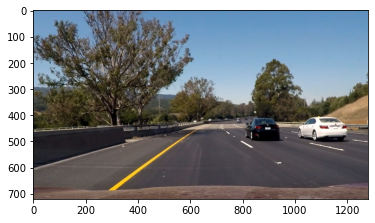

In [140]:
#reading in an image
#img = mpimg.imread('test_images/signs_vehicles_xygrad.png')
#img = mpimg.imread('test_images/straight_lines1.jpg')
#img = mpimg.imread('test_images/straight_lines2.jpg')
#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
#img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('test_images/test5.jpg')
img = mpimg.imread('test_images/test6.jpg')

#img = mpimg.imread('camera_cal/calibration9.jpg')

# ATTENTION: If you are using cv2.imread() or the glob API, this will read in a BGR image and you should convert to grayscale
# (in later image processing steps) using cv2.COLOR_BGR2GRAY.

#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)  # single color channel image, e.g. gray , call as plt.imshow(gray, cmap='gray')

### Distortion correction

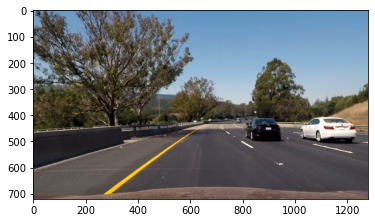

In [141]:
undist = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undist)

### Convert to grayscale (Is this step necessary here? Don't think so because then, color&gradient threshold is not possible any more)

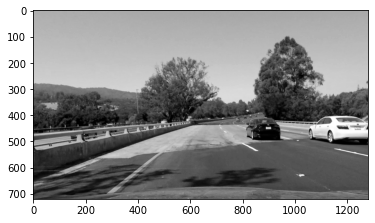

In [80]:
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

### Find the chessboard corners (is this really necessary? I think no.)

In [50]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
print('ret: ', ret)
print('corners: ', corners)

ret:  False
corners:  None


### Color & Gradient Threshold

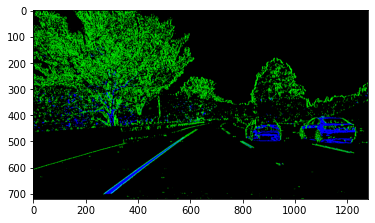

In [147]:
#pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100))
result = pipeline(undist)
plt.imshow(result)

### Perspective Transform to "birds-eye view"

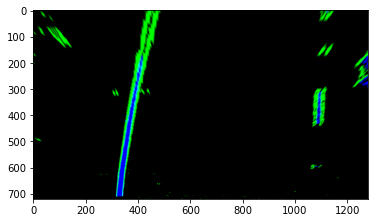

In [143]:
top_down, perspective_M = warp(result, 9, 6, mtx, dist)
plt.imshow(top_down)

### Detect lane pixels implementing sliding windows and fit a polynomial to find the lane boundary

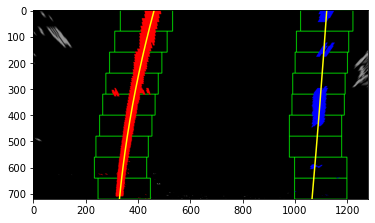

In [158]:
binary_warped = cv2.cvtColor(top_down, cv2.COLOR_BGR2GRAY)
#plt.imshow(binary_warped, cmap='gray')
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

### Skip the sliding windows step once you've found the lines / Search from prior

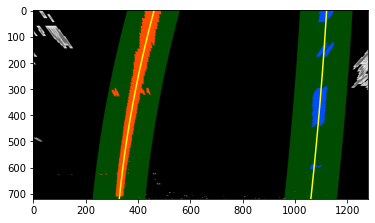

In [162]:
# Load our image - this should be a new frame since last time!
#binary_warped = mpimg.imread('warped_example.jpg')
#binary_warped = cv2.cvtColor(top_down, cv2.COLOR_BGR2GRAY)

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result2 = search_around_poly(binary_warped)

# View your output
plt.imshow(result2)

## Pipeline (video)

In [ ]:
import os #This module provides a portable way of using operating system dependent functionality.
os.listdir("test_images/")

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 3) # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally

    #canny
    low_threshold = 80
    high_threshold = 220
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Select a region of interest
    # the origin (x=0, y=0) is in the upper left
    left_bottom = np.array([0, 539])
    right_bottom = np.array([900, 539])
    apex = np.array([500, 310])
    vertices = np.array([left_bottom, right_bottom, apex])
    masked_edges = region_of_interest(edges, [vertices])
    
    # Define the Hough transform parameters and apply
    rho = 1 # units of pixels
    theta = np.pi/180 # units of radians
    threshold = 3 # minimum number of intersections a candidate line needs to have to make it into the output
    min_line_len = 5 # minimum length of a line (in pixels) that you will accept in the output
    max_line_gap = 3 # maximum distance (in pixels) between segments that you will allow to be connected into a single line
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) # a blank image (all black) with lines drawn on it.

    # combine the line_image with the initial image
    # The result image is computed as follows: initial_img * α + img * β + γ; NOTE: initial_img and img must be the same shape!
    combo = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    return combo

Testing on a video:

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so .subclip(start_second,end_second) was added
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline:

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Issues Discussion

### Description of Problems

### Solutions to the problems